# Rainfall COMPETITION:

## 1. Understand Data
## 2. Handle missing data (Skip since no data missing)
## 3. Feature Engineering
## 4. Compare ML models
## 5. Parameter Tunning per model
## 6. Best results

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


## 1.  Understand Data

In [2]:
# Load the data
train_data = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")

# Check the data
train_data.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [3]:
#quick look at our data types & null counts 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB


In [4]:
train_data.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

In [5]:
# Ensure train_data is loaded
# train_data = pd.read_csv("your_file.csv")  # Uncomment if applicable

X = train_data.copy()
days=X.pop("day")
y = X.pop("rainfall")
print(y.value_counts())
print(y.value_counts(normalize=True))  # To see proportions


rainfall
1    1650
0     540
Name: count, dtype: int64
rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64


In [6]:
# function for MI scores
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features):
    # Ensure X and y contain no NaN values
     # Ensure X and y contain no NaN values
    if X.isna().sum().sum() > 0 or y.isna().sum() > 0:
        raise ValueError("X or y contains NaN values!")
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [7]:

# Label encoding for categorical variables
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Identify discrete features correctly
discrete_features = X.dtypes == int
print(discrete_features)


print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Missing values in X: {X.isna().sum().sum()}, Missing values in y: {y.isna().sum()}")

if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("X or y is empty after preprocessing!")
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
#mi_scores = make_mi_scores(X, y, discrete_features)
print(mi_scores)


id                True
pressure         False
maxtemp          False
temparature      False
mintemp          False
dewpoint         False
humidity         False
cloud            False
sunshine         False
winddirection    False
windspeed        False
dtype: bool
X shape: (2190, 11), y shape: (2190,)
Missing values in X: 0, Missing values in y: 0
cloud            0.222167
sunshine         0.174307
humidity         0.122371
id               0.066873
maxtemp          0.028771
temparature      0.025509
windspeed        0.014131
dewpoint         0.010260
pressure         0.007370
winddirection    0.006889
mintemp          0.006635
Name: MI Scores, dtype: float64


# Analysis MI Scores

* We can see that humidity, sunshine and cloud are the most important features to consider. Ofc, other features should be considere like Temperature or pressure. 

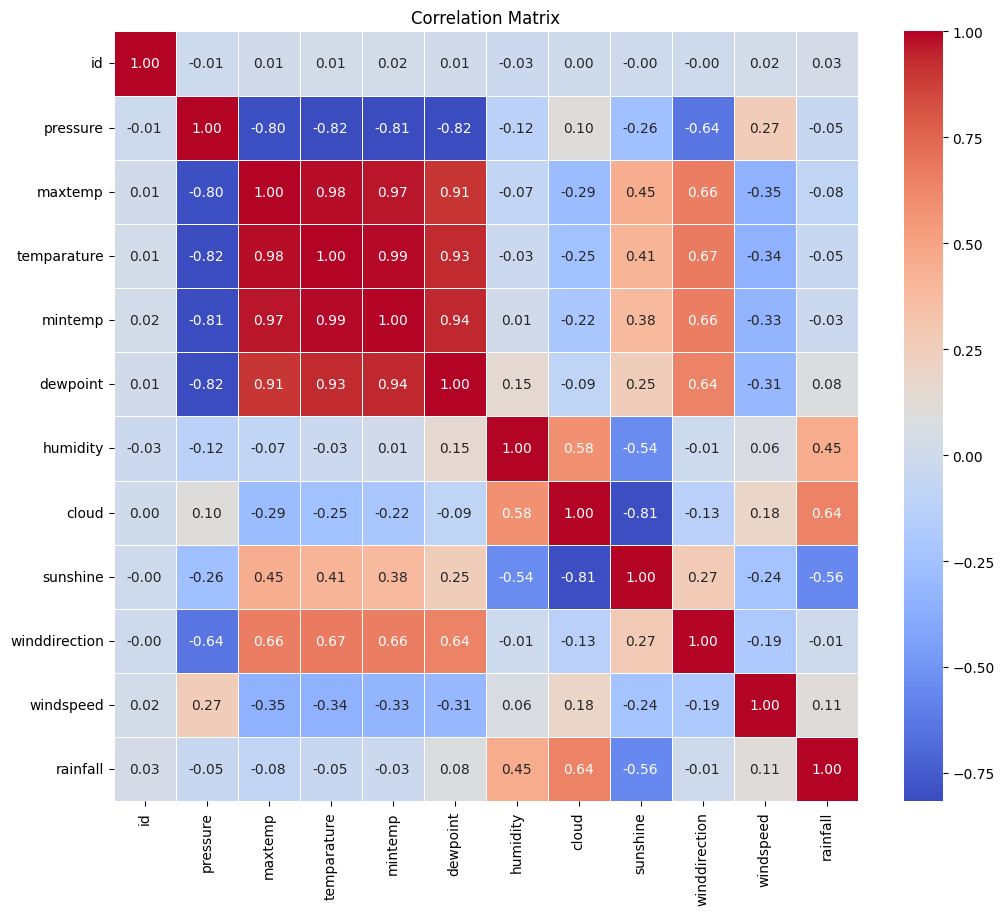

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for all features
corr_matrix = X.join(y).corr()  # Joining y to X for correlation with target
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Analysis correlation matrix
* We have 3 temperatures variables which are close to each others, maybe fitting the model to these 3 features would help much.
* The pressure is closely related to the temperature, this probably a thermodynamic property so T and P has some linear mathematical relation (PV = nkBT for example).
* Wind Speed and Winddirection are closely related to temperature and pressure
* Sunshine and Cloud are inversly related (that's a bit obvious)

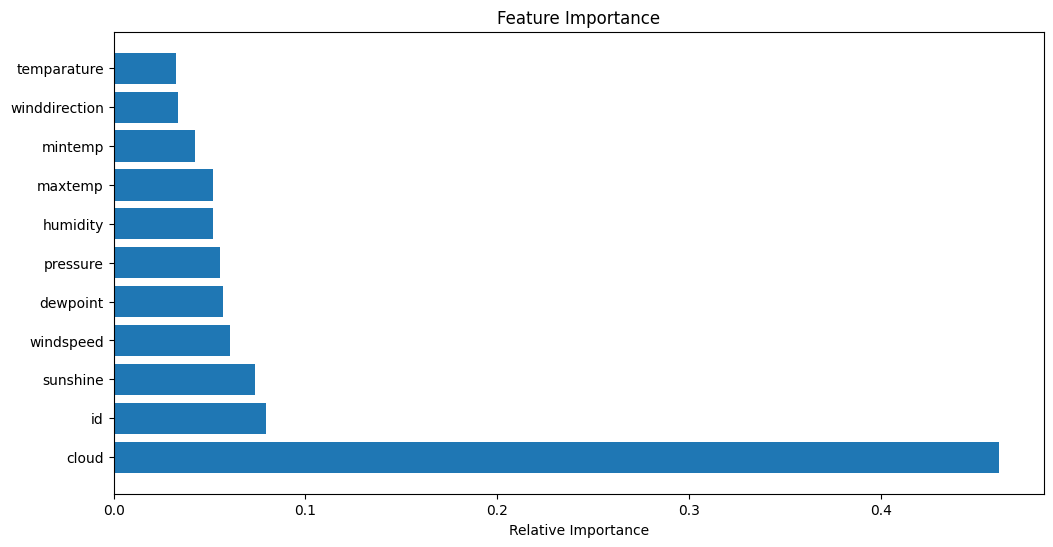

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Fit a random forest model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

# Plot feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel("Relative Importance")
plt.show()


* This shows what we discussed before but **cloud** is logically the most important feature
* So main point: we can drop  "mintemp", "maxtemp", "winddirection" since they don't give us more info than the remaining features 

## 3.  Feature engineering

In [10]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

train_data["day"] = pd.date_range(start="2020-01-01", periods=len(train_data), freq="D")
train_data_tm = train_data.set_index("day").to_period("D")


Shape of X_s: (2190, 17)


Index(['id', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall', 'day_s', 'week', 'dayofyear', 'year', 'month'],
      dtype='object')

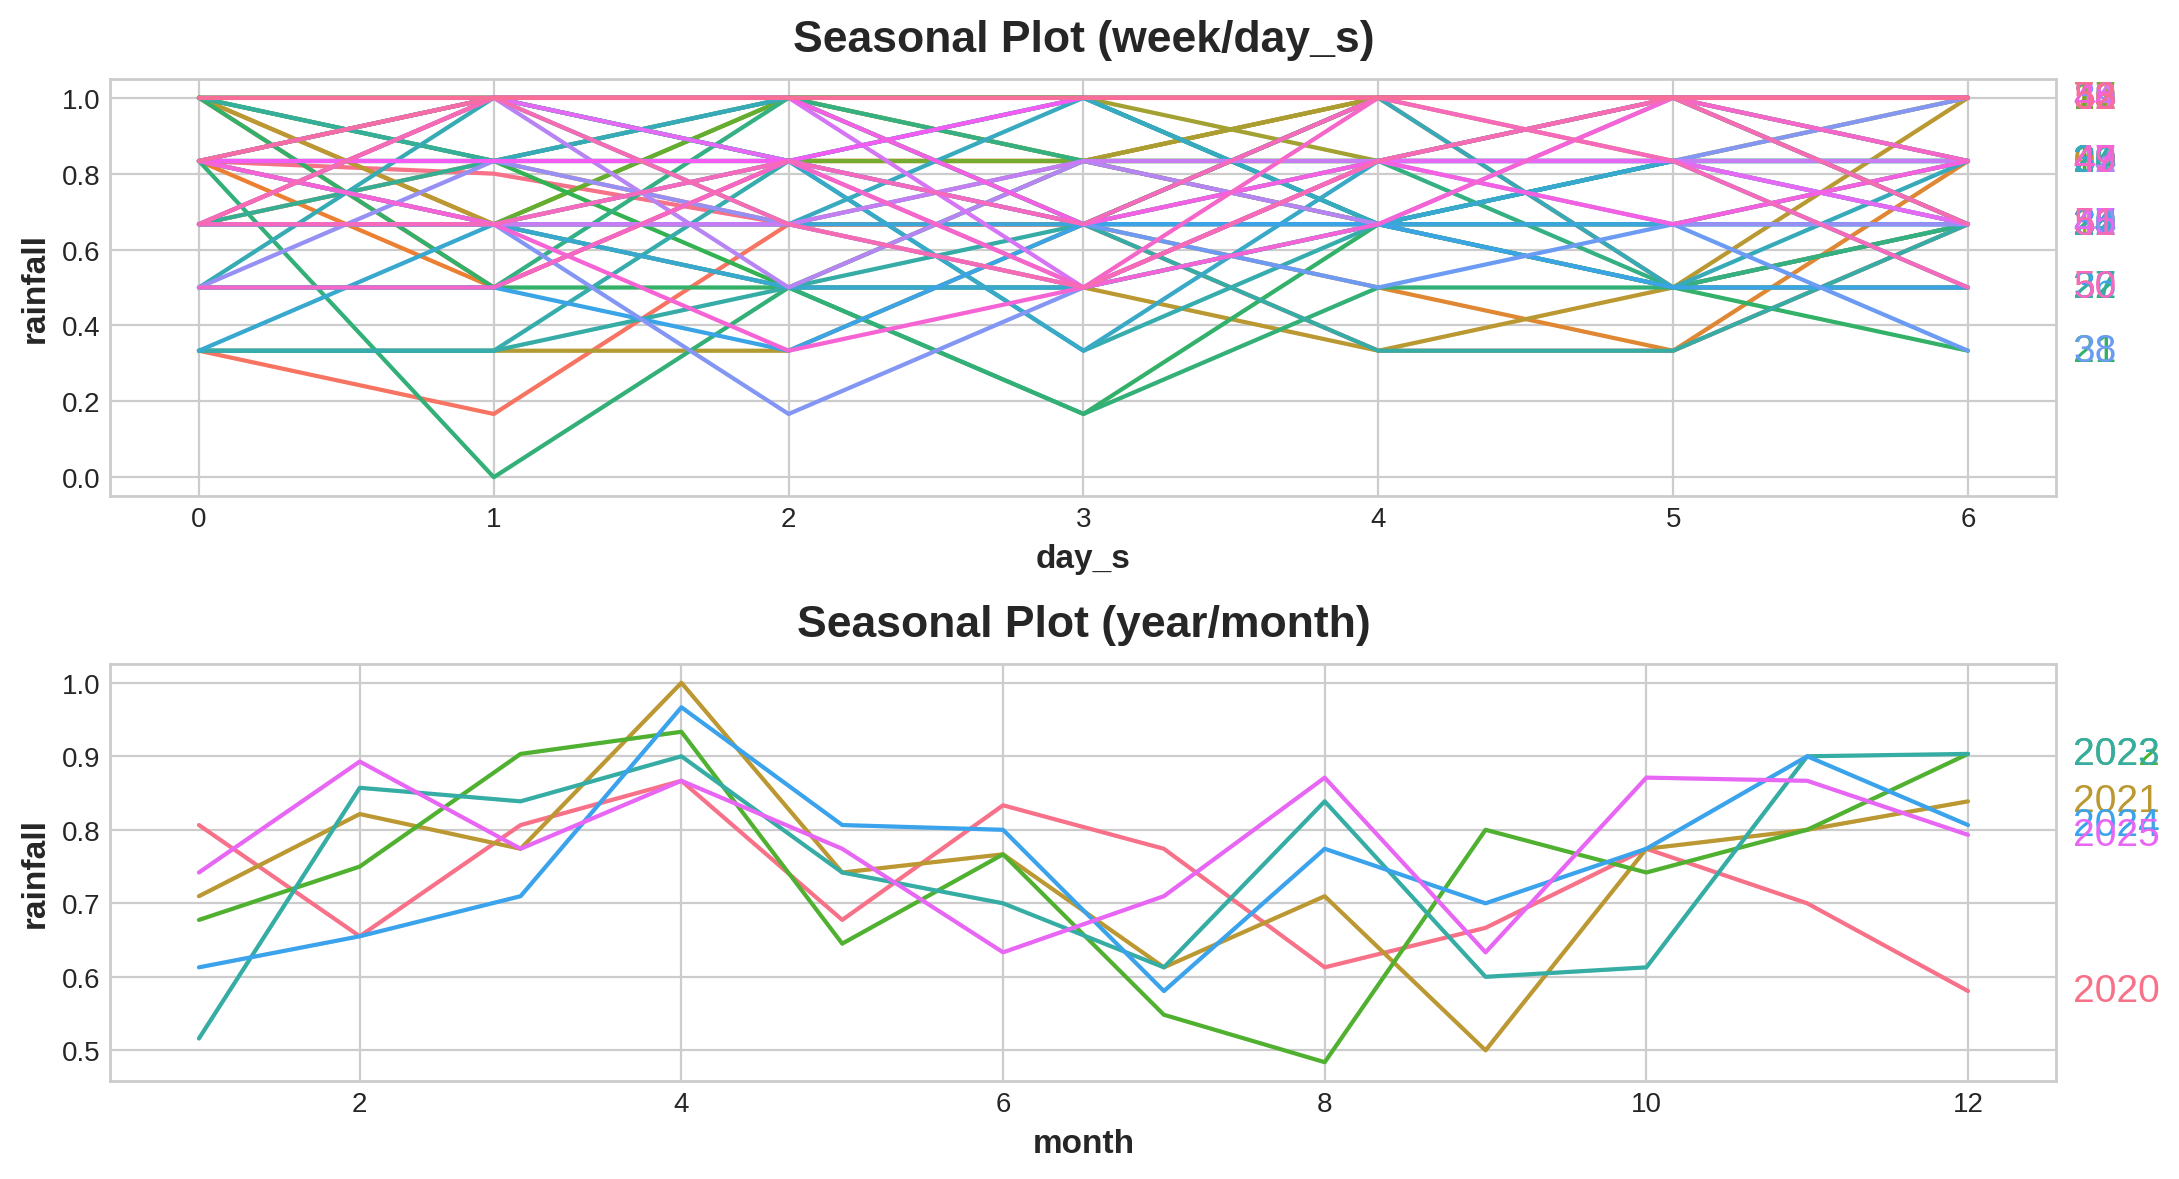

In [11]:
X_s = train_data_tm.copy()

# Convert index to datetime if needed
if isinstance(X_s.index, pd.PeriodIndex):
    X_s.index = X_s.index.to_timestamp()

# days within a week
X_s["day_s"] = X_s.index.dayofweek  
X_s["week"] = X_s.index.isocalendar().week  

# days within a year

X_s["dayofyear"] = X_s.index.dayofyear
X_s["year"] = X_s.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X_s, y="rainfall", period="week", freq="day_s", ax=ax0)  
X_s["month"] = X_s.index.month
seasonal_plot(X_s, y="rainfall", period="year", freq="month", ax=ax1)
# Make sure that X_s has the same length as y

print(f"Shape of X_s: {X_s.shape}")
X_s.columns

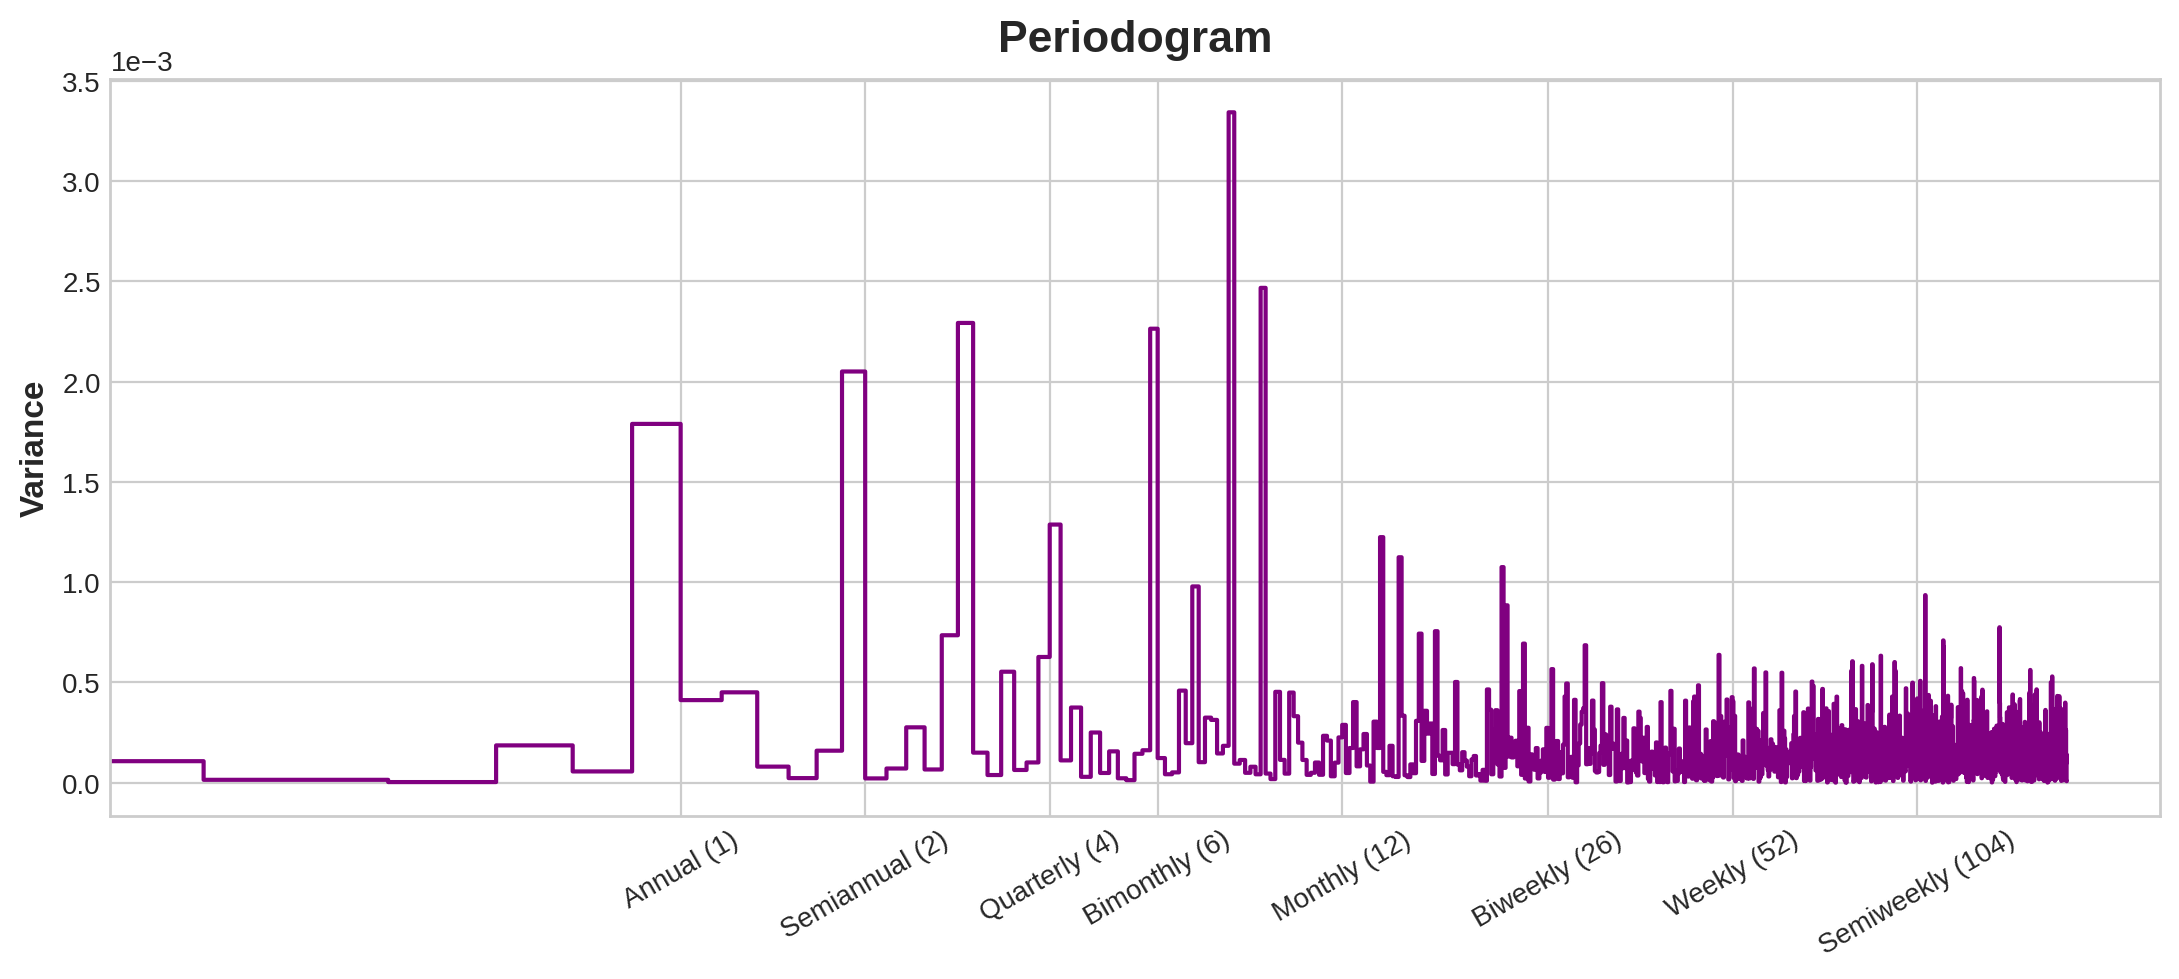

In [12]:
plot_periodogram(train_data_tm.rainfall);


* We can see that the frequency of importance are Annual, semiannual, Quaterly, Bimontly, since we dropped from monthly, this is **in agreement with the cycles of the year (winter, summmer...)** so we can take as frequency bimontly for the seasonality
* Obvious confirmation but this step could be done in different time depended problem, so important to know

In [13]:
print(train_data["rainfall"].value_counts())
print(train_data["rainfall"].value_counts(normalize=True))  # To see proportions


rainfall
1    1650
0     540
Name: count, dtype: int64
rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64


In [14]:

# Fourier Terms for yearly Periodicity
X_s['fourier_sin_annual'] = np.sin(2 * np.pi * X_s['dayofyear'] / 365)
X_s['fourier_cos_annual'] = np.cos(2 * np.pi * X_s['dayofyear'] / 365)
# Fourier Terms for semiAnnual Periodicity
X_s['fourier_sin_semiannual'] = np.sin(2 * np.pi * X_s['dayofyear'] / 180)
X_s['fourier_cos_semiannual'] = np.cos(2 * np.pi * X_s['dayofyear'] / 180)
#Decided to skip quaterfly because it won't give us more insights
# Fourier Terms for Bimonthly Periodicity
X_s['fourier_sin_bimonthly'] = np.sin(2 * np.pi * X_s['dayofyear'] / 60)
X_s['fourier_cos_bimonthly'] = np.cos(2 * np.pi * X_s['dayofyear'] / 60)

# Remember to delete unuseful features:
X_s = X_s.drop(columns=["mintemp", "maxtemp", "winddirection"])

# Check the resulting dataframe
print(X_s.head())

print(f"X_s shape: {X_s.shape}")
X_s.columns

            id  pressure  temparature  dewpoint  humidity  cloud  sunshine  \
day                                                                          
2020-01-01   0    1017.4         20.6      19.4      87.0   88.0       1.1   
2020-01-02   1    1019.5         16.9      15.4      95.0   91.0       0.0   
2020-01-03   2    1024.1         16.1       9.3      75.0   47.0       8.3   
2020-01-04   3    1013.4         17.8      16.8      95.0   95.0       0.0   
2020-01-05   4    1021.8         18.4       9.6      52.0   45.0       3.6   

            windspeed  rainfall  day_s  week  dayofyear  year  month  \
day                                                                    
2020-01-01       17.2         1      2     1          1  2020      1   
2020-01-02       21.9         1      3     1          2  2020      1   
2020-01-03       18.1         1      4     1          3  2020      1   
2020-01-04       35.6         1      5     1          4  2020      1   
2020-01-05       24.8

Index(['id', 'pressure', 'temparature', 'dewpoint', 'humidity', 'cloud',
       'sunshine', 'windspeed', 'rainfall', 'day_s', 'week', 'dayofyear',
       'year', 'month', 'fourier_sin_annual', 'fourier_cos_annual',
       'fourier_sin_semiannual', 'fourier_cos_semiannual',
       'fourier_sin_bimonthly', 'fourier_cos_bimonthly'],
      dtype='object')

In [15]:
# Drop 'rainfall' column from X_s before validation
X_s.drop(columns=["rainfall"], inplace=True)  # Removes only the 'rainfall' column

print(f"X_s shape: {X_s.shape}")
print(f"y shape: {y.shape}")
print(f"X colimns:{X_s.columns}")
X_s.head()

X_s shape: (2190, 19)
y shape: (2190,)
X colimns:Index(['id', 'pressure', 'temparature', 'dewpoint', 'humidity', 'cloud',
       'sunshine', 'windspeed', 'day_s', 'week', 'dayofyear', 'year', 'month',
       'fourier_sin_annual', 'fourier_cos_annual', 'fourier_sin_semiannual',
       'fourier_cos_semiannual', 'fourier_sin_bimonthly',
       'fourier_cos_bimonthly'],
      dtype='object')


,id,pressure,temparature,dewpoint,humidity,cloud,sunshine,windspeed,day_s,week,dayofyear,year,month,fourier_sin_annual,fourier_cos_annual,fourier_sin_semiannual,fourier_cos_semiannual,fourier_sin_bimonthly,fourier_cos_bimonthly
day,,,,,,,,,,,,,,,,,,,
2020-01-01,0,1017.4,20.6,19.4,87.0,88.0,1.1,17.2,2,1,1,2020,1,0.017213,0.999852,0.034899,0.999391,0.104528,0.994522
2020-01-02,1,1019.5,16.9,15.4,95.0,91.0,0.0,21.9,3,1,2,2020,1,0.034422,0.999407,0.069756,0.997564,0.207912,0.978148
2020-01-03,2,1024.1,16.1,9.3,75.0,47.0,8.3,18.1,4,1,3,2020,1,0.051620,0.998667,0.104528,0.994522,0.309017,0.951057
2020-01-04,3,1013.4,17.8,16.8,95.0,95.0,0.0,35.6,5,1,4,2020,1,0.068802,0.997630,0.139173,0.990268,0.406737,0.913545
2020-01-05,4,1021.8,18.4,9.6,52.0,45.0,3.6,24.8,6,1,5,2020,1,0.085965,0.996298,0.173648,0.984808,0.500000,0.866025


* Fourrier series data filled we can think of lag features like for weakly or monthly which might be a good  idea for time series forecasting assuming that test_data is a continuity of the training data timewise, This part good be tried later 

# 4. Models and Comparaison

* First attempts 

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_s, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "CatBoost": CatBoostClassifier(iterations=300, depth=10, learning_rate=0.05, loss_function='Logloss', cat_features=[], verbose=0),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=10, objective='binary', verbose=-1),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=10, objective='binary:logistic', eval_metric="logloss",verbosity=0),
    "HistGradientBoosting": HistGradientBoostingClassifier(max_iter=300, learning_rate=0.05, max_depth=10)
}

# Dictionary to store scores
model_scores = {}

# Evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predict probabilities
    prob_train = model.predict_proba(X_train)[:, 1]
    prob_valid = model.predict_proba(X_valid)[:, 1]
    
    # Evaluate performance
    auc_train = roc_auc_score(y_train, prob_train)
    auc_valid = roc_auc_score(y_valid, prob_valid)
    
    # Store the results
    model_scores[name] = {
        "Train AUC": auc_train,
        "Valid AUC": auc_valid,
    }

# Display model comparison
model_scores_df = pd.DataFrame(model_scores).T
print(model_scores_df)


                      Train AUC  Valid AUC
Logistic Regression    0.904356   0.868997
Random Forest          1.000000   0.851110
Gradient Boosting      0.972193   0.855668
CatBoost               1.000000   0.850109
LightGBM               1.000000   0.832302
XGBoost                1.000000   0.829641
HistGradientBoosting   1.000000   0.843971


# ANALYSIS
* Waw logistic regression might be the one but mainly we can see that **Logistic Regression, Random Forest, Gradient Boosting**  are the main winners maybe with parameter tunning we can have better results or maybe ensemble classifiers
* Several models (Random Forest, CatBoost, LightGBM, XGBoost, HistGradientBoosting) show a perfect train AUC of 1.0. This is often an indicator of **overfitting**, where the model is memorizing the training data but not generalizing well to the validation data.
This suggests that these models might benefit from regularization or hyperparameter tuning to reduce overfitting.
Logistic Regression and Gradient Boosting are less prone to overfitting compared to others, as their train AUCs are not perfectly 1.0.
* The best validation AUC score comes from Logistic Regression with 0.869. This indicates that despite its simple nature, it is generalizing well to unseen data.
* Random Forest, Gradient Boosting, CatBoost, and HistGradientBoosting all have validation AUCs around 0.85, suggesting they are performing similarly but are likely overfitting the training data.
* XGBoost and LightGBM have slightly lower validation AUCs (around 0.83), but their performance is still competitive.

# 5. Hyperparameter Tuning and Suggestions

1. Logistic Regression

In [17]:
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.01],   # Regularization strength
    'penalty': ['l2'],               # Regularization type
    'solver': ['liblinear']          # Solver for small datasets
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_s, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: ", grid_search.best_score_)
# Logistic Regression Results (After Hyperparameter Tuning)
log_reg_best = grid_search.best_score_
log_reg_grid = grid_search.best_params_


Best Parameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best AUC:  0.8930583613916948


2. Random forest 

In [18]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=1000)

param_grid = {
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [4],
    'max_features': ['auto', 'sqrt'],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_s, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: ", grid_search.best_score_)
# Random Forest Results (After Hyperparameter Tuning)
rf_best = grid_search.best_score_
rf_grid = grid_search.best_params_


Best Parameters:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}
Best AUC:  0.8800897867564534


3.  Gradient Boosting

In [19]:
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier(n_estimators=300)

param_grid = {
    'learning_rate': [0.05],
    'max_depth': [3],
    'min_samples_split': [10],
    'min_samples_leaf': [4],
}

grid_search = GridSearchCV(gb, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_s, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: ", grid_search.best_score_)
# Gradient Boosting Results (After Hyperparameter Tuning)
gb_best = grid_search.best_score_
gb_grid = grid_search.best_params_


Best Parameters:  {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best AUC:  0.857250280583614


4. CatBoost

In [20]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=300, cat_features=[], verbose=0)

param_grid = {
    'depth': [6],
    'learning_rate': [0.01],
    'l2_leaf_reg': [5],
    'border_count': [32],
}

grid_search = GridSearchCV(catboost, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_s, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: ", grid_search.best_score_)
# CatBoost Results (After Hyperparameter Tuning)
catboost_best = grid_search.best_score_
catboost_grid = grid_search.best_params_


Best Parameters:  {'border_count': 32, 'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
Best AUC:  0.8853086419753087


5. LightGBM

In [21]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=300,verbose=-1)

param_grid = {
    'learning_rate': [0.01],
    'max_depth': [5],
    'num_leaves': [31],
    'min_data_in_leaf': [40],
}

grid_search = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_s, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: ", grid_search.best_score_)
# LightGBM Results (After Hyperparameter Tuning)
lgbm_best = grid_search.best_score_
lgbm_grid = grid_search.best_params_

Best Parameters:  {'learning_rate': 0.01, 'max_depth': 5, 'min_data_in_leaf': 40, 'num_leaves': 31}
Best AUC:  0.8814309764309763


6. XGB 

In [22]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=300,verbosity=0)

param_grid = {
    'learning_rate': [0.01],
    'max_depth': [3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_s, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best AUC: ", grid_search.best_score_)
# XGBoost Results (After Hyperparameter Tuning)
xgb_best = grid_search.best_score_
xgb_grid = grid_search.best_params_

Best Parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8}
Best AUC:  0.8877553310886643


In [23]:
# Now store the results in a single dictionary, including validation and test AUC
best_results = {
    "Model": [
        "Logistic Regression", "Random Forest", "Gradient Boosting", 
        "CatBoost", "LightGBM", "XGBoost"
    ],
    "Validation AUC": [
        log_reg_best, rf_best, gb_best, 
        catboost_best, lgbm_best, xgb_best
    ],
    "Test AUC": [
        0.84955, 0.8751, 0.8192, 0.8584, 0.8456, 0.83896  # Add the test results here
    ],
    "Best Parameters": [
        log_reg_grid, rf_grid, gb_grid, 
        catboost_grid, lgbm_grid, xgb_grid
    ]
}

# Convert to DataFrame
results_df = pd.DataFrame(best_results)

# Display the table
from tabulate import tabulate
print("\nHyperparameter Tuning Results:\n")
print(tabulate(results_df, headers="keys", tablefmt="fancy_grid"))



Hyperparameter Tuning Results:

╒════╤═════════════════════╤══════════════════╤════════════╤══════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Model               │   Validation AUC │   Test AUC │ Best Parameters                                                                          │
╞════╪═════════════════════╪══════════════════╪════════════╪══════════════════════════════════════════════════════════════════════════════════════════╡
│  0 │ Logistic Regression │         0.893058 │    0.84955 │ {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}                                      │
├────┼─────────────────────┼──────────────────┼────────────┼──────────────────────────────────────────────────────────────────────────────────────────┤
│  1 │ Random Forest       │         0.88009  │    0.8751  │ {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5} │
├────┼─────────────────────┼──────────────────┼────────

# ⭐ Best model: 

# Validation: Logistic Regression with AUC: 0.893058   
# TEST: After submission we get RandomForest with 0.875

# Improvement ideas: 
* lag features improvement and time series 
* Feature selection: I assumed that the 2 values of temperatures aren't important but maybe we can add the difference as a feature along with the temperature. Another case, maybe we can ignore sunshine and keep only cloud or use just a combined feature.
* Try a time independant analysis (saw this idea in discussions)


# 6. Final Results

Preprocess X_test to be in the same format as our trainning preprocessed format

In [24]:
# Now, generate X_test by continuing the date range from the last date of train_data
last_date = X_s.index[-1]  # The last date in train_data
n_test_samples = len(test_data)  # The number of samples in the test data

# Generate the "day" column for X_test, starting from the next day
test_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=n_test_samples, freq="D")

# Add the "day" column to X_test and continue the feature extraction process
test_data["day"] = test_dates
tunnel_test = test_data.set_index("day").to_period("D")

X_test = tunnel_test.copy()
# Convert index to datetime if needed
if isinstance(X_test.index, pd.PeriodIndex):
    X_test.index = X_test.index.to_timestamp()

# Extract the same time-based features for X_test as you did for X_s
X_test["day_s"] = X_test.index.dayofweek
X_test["week"] = X_test.index.isocalendar().week
X_test["dayofyear"] = X_test.index.dayofyear
X_test["year"] = X_test.index.year
X_test["month"] = X_test.index.month

# Fourier terms for bimonthly and annual periodicity
X_test['fourier_sin_annual'] = np.sin(2 * np.pi * X_test['dayofyear'] / 365)
X_test['fourier_cos_annual'] = np.cos(2 * np.pi * X_test['dayofyear'] / 365)
# Fourier Terms for semiAnnual Periodicity
X_test['fourier_sin_semiannual'] = np.sin(2 * np.pi * X_test['dayofyear'] / 180)
X_test['fourier_cos_semiannual'] = np.cos(2 * np.pi * X_test['dayofyear'] / 180)
#Decided to skip quaterfly because it won't give us more insights
X_test['fourier_sin_bimonthly'] = np.sin(2 * np.pi * X_test['dayofyear'] / 60)
X_test['fourier_cos_bimonthly'] = np.cos(2 * np.pi * X_test['dayofyear'] / 60)
# Remember to delete unuseful features:
X_test = X_test.drop(columns=["mintemp", "maxtemp", "winddirection"])
X_test.columns

# Now, X_test is ready with the same features as X_s for making predictions

Index(['id', 'pressure', 'temparature', 'dewpoint', 'humidity', 'cloud',
       'sunshine', 'windspeed', 'day_s', 'week', 'dayofyear', 'year', 'month',
       'fourier_sin_annual', 'fourier_cos_annual', 'fourier_sin_semiannual',
       'fourier_cos_semiannual', 'fourier_sin_bimonthly',
       'fourier_cos_bimonthly'],
      dtype='object')

In [25]:
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Best hyperparameters for each model, replaced with corresponding variables
#best_params = {
#    "Logistic Regression": log_reg_grid,
#    "Random Forest": rf_grid,
#    "Gradient Boosting": gb_grid,
#    "CatBoost": catboost_grid,
#    "LightGBM": lgbm_grid,
#    "XGBoost": xgb_grid,
#    "HistGradientBoosting": hgb_grid
#}
# Best hyperparameters for each model
best_params = {
    "Logistic Regression": {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'},
    "Random Forest": {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5},
    "Gradient Boosting": {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10},
    "CatBoost": {'border_count': 32, 'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.01},
    "LightGBM": {'learning_rate': 0.01, 'max_depth': 5, 'min_data_in_leaf': 40, 'num_leaves': 31},
    "XGBoost": {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8},
    "HistGradientBoosting": {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 20}
}

# Define models
models = {
    "Logistic Regression": LogisticRegression,
    "Random Forest": RandomForestClassifier,
    "Gradient Boosting": GradientBoostingClassifier,
    "CatBoost": CatBoostClassifier,
    "LightGBM": LGBMClassifier,
    "XGBoost": XGBClassifier,
    "HistGradientBoosting": HistGradientBoostingClassifier
}

# Loop through each model, train it, and save predictions
for model_name, model_class in models.items():
    print(f"Training {model_name}...")

    # Initialize model with best parameters
    model = model_class(**best_params[model_name])

    # Train the model
    model.fit(X_s, y)

    # Make predictions
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability scores

    # Save predictions to CSV
    final_predictions = pd.DataFrame({
        "id": test_data["id"],  # Ensure test_data contains 'id' column
        "rainfall_probability": y_pred_prob
    })
    
    # Save to CSV
    filename = f"{model_name.replace(' ', '_').lower()}_best_predictions.csv"
    final_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}\n")


Training Logistic Regression...
Saved predictions to logistic_regression_best_predictions.csv

Training Random Forest...
Saved predictions to random_forest_best_predictions.csv

Training Gradient Boosting...
Saved predictions to gradient_boosting_best_predictions.csv

Training CatBoost...
0:	learn: 0.6844153	total: 1.98ms	remaining: 1.98s
1:	learn: 0.6762035	total: 3.79ms	remaining: 1.89s
2:	learn: 0.6678521	total: 5.71ms	remaining: 1.9s
3:	learn: 0.6596980	total: 7.49ms	remaining: 1.86s
4:	learn: 0.6528668	total: 9.35ms	remaining: 1.86s
5:	learn: 0.6453257	total: 11.2ms	remaining: 1.86s
6:	learn: 0.6391377	total: 13ms	remaining: 1.84s
7:	learn: 0.6329574	total: 14.6ms	remaining: 1.81s
8:	learn: 0.6260399	total: 16.4ms	remaining: 1.81s
9:	learn: 0.6187022	total: 18.2ms	remaining: 1.8s
10:	learn: 0.6121577	total: 20.1ms	remaining: 1.81s
11:	learn: 0.6059973	total: 22ms	remaining: 1.81s
12:	learn: 0.5999488	total: 24ms	remaining: 1.82s
13:	learn: 0.5938875	total: 25.8ms	remaining: 1.82s
